In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import pyro.infer as infer
import pyro.optim as optim

torch.manual_seed(101)

## Tutorial - Part 1

In [3]:
loc = 0.
scale = 1.

normal = dist.Normal(loc, scale)

In [4]:
x = normal.sample()

In [6]:
print("sample", x)

sample tensor(-0.2460)


In [8]:
normal.log_prob(x)

tensor(-0.9492)

In [9]:
x = pyro.sample("my_sample", normal)
print(x)

tensor(-0.2629)


In [12]:
def weather():
    cloudy = pyro.sample("cloudy", dist.Bernoulli(0.3))
    cloudy = "cloudy" if cloudy.item() == 1.0 else "sunny"
    
    mean_temp = {"cloudy": 55.0, "sunny": 75.0}[cloudy]
    scale_temp = {"cloudy": 10.0, "sunny": 15.0}[cloudy]
    
    temp = pyro.sample("temp", dist.Normal(mean_temp, scale_temp))
    
    return cloudy, temp.item()

In [16]:
for _ in range(3):
    print(weather())

('cloudy', 54.47017288208008)
('sunny', 83.77517700195312)
('sunny', 56.14234161376953)


In [17]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == "sunny" and temp > 80.0 else 50.
    
    ice_cream = pyro.sample("ice_cream", dist.Normal(expected_sales, 10.0))
    return ice_cream

In [19]:
ice_cream_sales()

tensor(59.7376)

In [20]:
def geometric(p, t=None):
    if t is None:
        t = 0
    
    x = pyro.sample(f"x_{t}", dist.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

In [36]:
geometric(0.2)

4

In [37]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", dist.Normal(loc, scale))
    z2 = pyro.sample("z2", dist.Normal(loc, scale))
    
    return z1 * z2

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", dist.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

In [41]:
make_normal_normal()(1.)

tensor(0.1487)

## Tutorial - Part 2

In [57]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [60]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [61]:
guess = 8.5

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))
marginal()

tensor(7.7274)

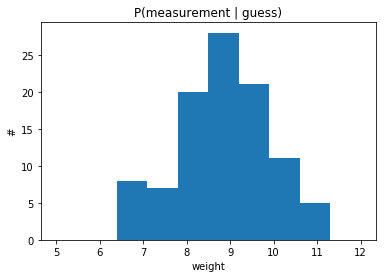

In [66]:
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#");

In [74]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In [75]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

In [76]:
def scale_obs(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we attach an observation measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.),
                       obs=9.5)

In [77]:
def scale2(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = torch.abs(pyro.sample("tolerance", dist.Normal(0., 1.)))
    return pyro.sample("measurement", dist.Normal(weight, tolerance))

# conditioning composes:
# the following are all equivalent and do not interfere with each other
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": 9.2}),
    data={"measurement": 9.5})

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": 9.5}),
    data={"weight": 9.2})

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": 9.2, "measurement": 9.5})

tensor(10.1412)


Text(0,0.5,'#')

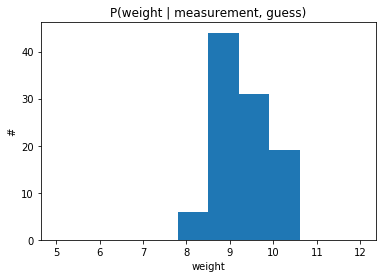

In [78]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="weight")

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

In [79]:
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.Normal(guess, 1.))

posterior = pyro.infer.Importance(conditioned_scale,
                                  guide=scale_prior_guide,
                                  num_samples=10)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

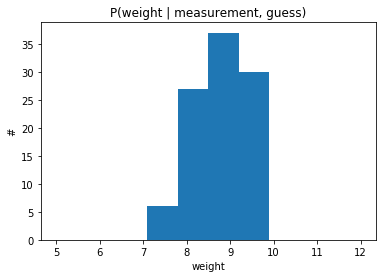

In [81]:
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = 1. / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.Normal(a, b))

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess), sites="weight")
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

In [83]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(torch.randn(1) + guess))
    b = pyro.param("b", torch.randn(1))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

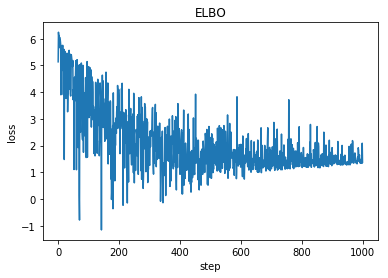

In [85]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

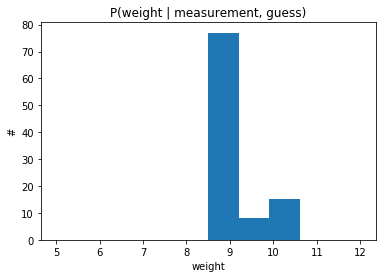

In [87]:

posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

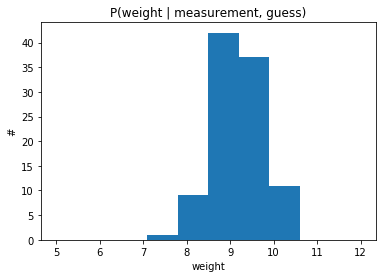

In [88]:
plt.hist([scale_parametrized_guide(guess).item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");